# Granger Causality Test


Granger Causality test is a statistical test that is used to determine if a given time series and it’s lags is helpful in explaining the value of another series. In Python it can be implemented using the statsmodels package.

Since our data is very fluctuating, we are going to aggregate it by week to reduce noise and provide a smoother trend.

Before performing the Granger Causality test, it's essential to check if the time series variables are stationary. Stationarity can be assessed using statistical tests such as the Augmented Dickey-Fuller (ADF) test.

# Set up the environment

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Additional Functions

In [3]:
def granger_causality_matrix(data, variables, maxlag, test='ssr_chi2test', verbose=False):
    """
    Check Granger Causality of all possible combinations of the Time series.

    The rows represent the response variables, and the columns represent the predictors.
    The values in the table are the P-Values. P-Values less than the significance level (0.05) imply
    rejection of the Null Hypothesis, suggesting that the coefficients of the corresponding past values are
    non-zero, indicating that the X variable causes Y.

    Parameters:
    - data (DataFrame): A pandas DataFrame containing the time series variables.
    - variables (list): A list containing the names of the time series variables.
    - maxlag (int): The maximum lag to consider for Granger Causality testing.
    - test (str): The statistical test to use. Default is 'ssr_chi2test'.
    - verbose (bool): Whether to print verbose output. Default is False.

    Returns:
    DataFrame: A DataFrame containing the P-Values for Granger Causality tests between the variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1], 4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df


def check_stationarity(data):
    """
    Perform the Augmented Dickey-Fuller test to check for stationarity in a time series.

    Parameters:
    - data (array-like): The time series data to be tested.

    Returns:
    - bool: True if the time series is stationary, False otherwise.
    """
    result = adfuller(data)
    p_value = result[1]
    if p_value < 0.05:
        return True  # Reject the null hypothesis (stationary)
    else:
        return False  # Fail to reject the null hypothesis (non-stationary)

# Count of Documents Mentioning Ukraine

In [4]:
# Load data for the test
combined_data_counts_weekly = pd.read_csv('granger_causality_test_data/combined_data_counts_weekly.csv')
combined_data_counts_weekly = combined_data_counts_weekly.drop('Date', axis=1)
combined_data_counts_weekly.columns = ['The European Commission', 'The White House']

In [5]:
# Check data for stationarity
print('Counts:')
print(f"The European Commission time series is stationary: \
      {check_stationarity(combined_data_counts_weekly['The European Commission'])}")
print(f"The White House time series is stationary: \
      {check_stationarity(combined_data_counts_weekly['The White House'])}")

Counts:
The European Commission time series is stationary:       False
The White House time series is stationary:       False


In [6]:
# Apply Differencing to make the data stationary
combined_data_counts_weekly['The European Commission'] = combined_data_counts_weekly['The European Commission'] - combined_data_counts_weekly['The European Commission'].shift(1)
combined_data_counts_weekly['The White House'] = combined_data_counts_weekly['The White House'] - combined_data_counts_weekly['The White House'].shift(1)
combined_data_counts_weekly = combined_data_counts_weekly.dropna()

In [7]:
# Make sure data is stationary
print('Counts:')
print(f"The European Commission time series is stationary: \
      {check_stationarity(combined_data_counts_weekly['The European Commission'])}")
print(f"The White House time series is stationary: \
      {check_stationarity(combined_data_counts_weekly['The White House'])}")

Counts:
The European Commission time series is stationary:       True
The White House time series is stationary:       True


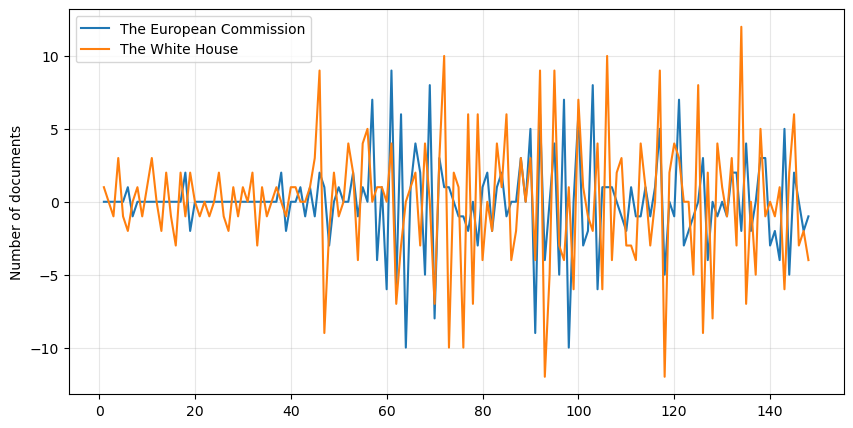

In [8]:
# Plot results
combined_data_counts_weekly.plot(figsize=(10,5))
plt.grid(alpha=.3)
plt.ylabel('Number of documents')
plt.show()

Data is stationary, good to go now!

In [9]:
# Perform the test on the number of documents mentioning Ukraine

print("Monthly Mentions of Ukraine (Counts)")
granger_causality_matrix(combined_data_counts_weekly, 
                          variables = combined_data_counts_weekly.columns, maxlag = 1)

Monthly Mentions of Ukraine (Counts)


,The European Commission_x,The White House_x
The European Commission_y,1.0000,0.018
The White House_y,0.8698,1.000


If the p-value is less than 0.05, we should reject the null hypothesis, which would suggest that there is evidence of Granger causality at a 5% significance level. So, in the above table, the p-value for X=White House and Y=European Commission is 0.018. Let’s introduce the hypotheses of this test:
- H0 (Null Hypothesis): The lagged values of The White House do not have a significant effect on predicting the The European Commission communications. In other words, there is no Granger causality between the two variables.
- H1 (Alternative Hypothesis): not H0.

So we reject the null hypothesis and conclude that the White House will likely be helpful in predicting the European Commission communication towards Ukraine. On the other hand, changes in the European Commission communications do not Granger cause the White House communication. This means that changes in the European Commission communications data does not improve the White House communications prediction performance.

# Topic Shares

In [139]:
data = pd.read_csv('granger_causality_test_data/combined_weekly_data.csv')

# Filtering rows where date contains "2023"
data = data[~data['date'].str.contains("2023")]

topics_shares = data[['ec_topic_7', 'wh_topic_7']]
topics_shares.columns = ['The European Commission', 'The White House']

In [140]:
# Check data for stationarity
print(f"The European Commission time series is stationary: \
      {check_stationarity(topics_shares['The European Commission'])}")

print(f"The White House time series is stationary: \
      {check_stationarity(topics_shares['The White House'])}")

The European Commission time series is stationary:       False
The White House time series is stationary:       True


In [141]:
# Apply Differencing to make the data stationary
topics_shares['The European Commission'] = topics_shares['The European Commission'] - topics_shares['The European Commission'].shift(1)
topics_shares = topics_shares.dropna()

In [142]:
# Make sure data is stationary
print(f"The European Commission time series is stationary: \
      {check_stationarity(topics_shares['The European Commission'])}")

print(f"The White House time series is stationary: \
      {check_stationarity(topics_shares['The White House'])}")

The European Commission time series is stationary:       True
The White House time series is stationary:       True


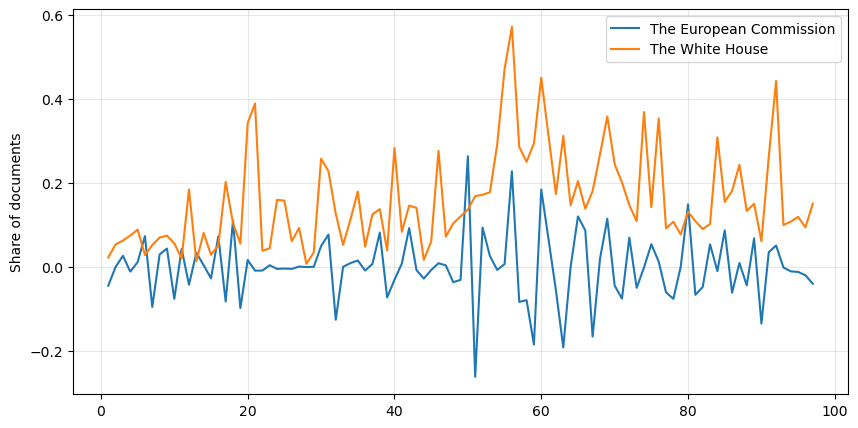

In [143]:
# Plot results
topics_shares.plot(figsize=(10,5))
plt.grid(alpha=.3)
plt.ylabel('Share of documents')
plt.show()

In [144]:
# Perform the test on the topic shares data

print("Ukraine topic share")
granger_causality_matrix(topics_shares, 
                          variables = topics_shares.columns, maxlag = 2)

Ukraine topic share


,The European Commission_x,The White House_x
The European Commission_y,1.0000,0.0562
The White House_y,0.1862,1.0000


We conducted an additional test on the weekly timeseries data from both the White House and the European Commission, focusing on the main topic of interest 'International Conflict and Ukraine'. The results of this test mirror those of the number of documents mentioning Ukraine. When X=The White House and Y=The European Commission, the results are significant at 6% significance level.